In [ ]:
from qiskit import Aer
from qiskit.utils import algorithm_globals
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import YahooDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization import QuadraticProgram
import numpy as np
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [ ]:
# Generate expected return and covariance matrix from time-series
all_stocks = [ "AMD", "GOOGL", "MSFT", "NVDA", "WMT", "AAPL", "AMZN", "TSLA", "IBM", "META", "UNH", "XOM", "PG", "MA", "HD", "CVX", "ABBV", "MRK", "AVGO", "PFE"]
#[ "AMD", "GOOGL", "MSFT", "NVDA", "WMT", "AAPL", "AMZN", "TSLA", "JPM", "JNJ","PYPL","EBAY"]

seed = 123

In [ ]:
import yfinance as yf
import pandas as pd

# Set the start and end date
start_date = '2017-01-01'
end_date = '2022-12-31'

# Create placeholder for data
data2 = pd.DataFrame(columns=all_stocks)

# Fetch the data
for ticker in all_stocks:
    data2[ticker] = yf.download(ticker, start_date,end_date)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

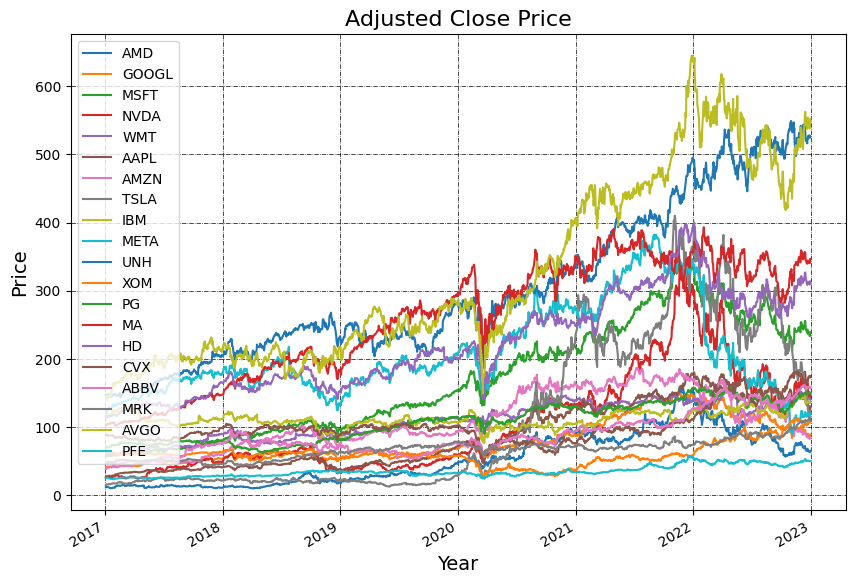

In [ ]:
data2.plot(figsize=(10, 7))

# Show the legend
plt.legend()

# Define the label for the title of the figure
plt.title("Adjusted Close Price", fontsize=16)

# Define the labels for x-axis and y-axis
plt.ylabel('Price', fontsize=14)
plt.xlabel('Year', fontsize=14)

# Plot the grid lines
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [ ]:
vqe_res = []
qaoa_res = []
for num_assets in range(4,21,2):
    stocks = all_stocks[0:num_assets]
    data = YahooDataProvider(
    tickers=stocks,
    start=datetime.datetime(2017, 1, 1),
    end=datetime.datetime(2022, 12, 31)
    )
    data.run()
    mu = data.get_period_return_mean_vector()
    sigma = data.get_period_return_covariance_matrix()
    # change accordingly
    q = 1.5 # set risk factor
    budget = num_assets // 2  # set budget
    penalty = num_assets  # set parameter to scale the budget penalty term

    portfolio = PortfolioOptimization(
        expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
    )
    qp = portfolio.to_quadratic_program()

    #VQE
    algorithm_globals.random_seed = 1234
    backend = Aer.get_backend("qasm_simulator")
    cobyla = COBYLA()
    cobyla.set_options(maxiter=500)
    ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
    vqe = MinimumEigenOptimizer(vqe_mes)
    result = vqe.solve(qp)
    vqe_res.append(result.x)

    #QAOA
    algorithm_globals.random_seed = 1234
    backend = Aer.get_backend("qasm_simulator")
    cobyla = COBYLA()
    cobyla.set_options(maxiter=250)
    quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)
    qaoa_res.append(result.x)

C:\Users\Aryan Raj\AppData\Local\Temp\ipykernel_29492\3141526023.py:28: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
C:\Users\Aryan Raj\AppData\Local\Temp\ipykernel_29492\3141526023.py:29: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
C:\Users\Aryan Raj\AppData\Local\Temp\ipykernel_29492\3141526023.py:39: DeprecationWarning: The class ``qiskit

In [ ]:
from scipy.optimize import minimize
import random
def portfolio(weights):
  weights = np.array(weights)
  expected_return = np.sum((returns.mean()* weights) * 252)
  expected_vol = np.sqrt(np.dot(weights.T,np.dot(returns.cov()*252,weights)))
  sharpe_r = expected_return/expected_vol
  return np.array([expected_return,expected_vol,sharpe_r])

def sr_negate(weights):
  neg_sr = portfolio(weights)[2] * -1
  return neg_sr

def weight_check(weights):
  weights_sum = np.sum(weights)
  return weights_sum - 1
def insert_tuples(n):
    return [(0, 1) for i in range(n)]

In [ ]:
vqe_assets=[]
vqe_sharpe = []
vqe_return = []
vqe_vol = []
for x in vqe_res:
    assets = []
    for i in range(len(x)):
        if(x[i] == 1):
            assets.append(all_stocks[i])
    vqe_assets.append(assets)
    data = pd.DataFrame(columns=assets)
    data[assets] = data2[assets]
    n = len(assets)
    returns=data.pct_change()
    weights = [random.random() for _ in range(n)]
    sum_weights = sum(weights)
    weights = [1*w/sum_weights for w in weights]
    constraints = ({'type':'eq','fun':weight_check})
    initial_guess = weights
    bounds=insert_tuples(n)
    results = minimize(sr_negate,weights,method='SLSQP',bounds=bounds,constraints=constraints)
    optimized_metrics = portfolio(results.x)
    vqe_return.append("{:.2f}%".format(optimized_metrics[0]*100))
    vqe_vol.append("{:.2f}%".format(optimized_metrics[1]*100))
    vqe_sharpe.append("{:.2f}".format(optimized_metrics[2]))

In [ ]:
qaoa_assets=[]
qaoa_sharpe = []
qaoa_return = []
qaoa_vol = []
for x in qaoa_res:
    assets = []
    for i in range(len(x)):
        if(x[i] == 1):
            assets.append(stocks[i])
    qaoa_assets.append(assets)
    data = pd.DataFrame(columns=assets)
    data[assets] = data2[assets]
    n = len(assets)
    returns=data.pct_change()
    weights = [random.random() for _ in range(n)]
    sum_weights = sum(weights)
    weights = [1*w/sum_weights for w in weights]
    constraints = ({'type':'eq','fun':weight_check})
    initial_guess = weights
    bounds=insert_tuples(n)
    results = minimize(sr_negate,weights,method='SLSQP',bounds=bounds,constraints=constraints)
    optimized_metrics = portfolio(results.x)
    qaoa_return.append("{:.2f}%".format(optimized_metrics[0]*100))
    qaoa_vol.append("{:.2f}%".format(optimized_metrics[1]*100))
    qaoa_sharpe.append("{:.2f}".format(optimized_metrics[2]))

In [ ]:
for x in range(4,21,2):
    print("Num of assets = ",x,"\nVQE : ",vqe_assets[int((x-4)/2)], vqe_return[int((x-4)/2)],vqe_vol[int((x-4)/2)],vqe_sharpe[int((x-4)/2)],"\nQAOA : ", qaoa_assets[int((x-4)/2)],qaoa_return[int((x-4)/2)],qaoa_vol[int((x-4)/2)],qaoa_sharpe[int((x-4)/2)], "\n")

Num of assets =  4 
VQE :  ['GOOGL', 'MSFT'] 28.01% 28.97% 0.97 
QAOA :  ['GOOGL', 'MSFT'] 28.01% 28.97% 0.97 

Num of assets =  6 
VQE :  ['GOOGL', 'WMT', 'AAPL'] 25.04% 23.43% 1.07 
QAOA :  ['MSFT', 'WMT', 'AAPL'] 25.18% 22.89% 1.10 

Num of assets =  8 
VQE :  ['MSFT', 'WMT', 'AAPL', 'TSLA'] 29.33% 24.62% 1.19 
QAOA :  ['GOOGL', 'MSFT', 'WMT', 'AAPL'] 25.18% 22.89% 1.10 

Num of assets =  10 
VQE :  ['MSFT', 'WMT', 'AAPL', 'AMZN', 'IBM'] 25.18% 22.89% 1.10 
QAOA :  ['GOOGL', 'MSFT', 'WMT', 'AAPL', 'IBM'] 25.18% 22.88% 1.10 

Num of assets =  12 
VQE :  ['GOOGL', 'WMT', 'AAPL', 'IBM', 'UNH', 'XOM'] 25.01% 21.78% 1.15 
QAOA :  ['GOOGL', 'MSFT', 'WMT', 'IBM', 'UNH', 'XOM'] 23.78% 21.29% 1.12 

Num of assets =  14 
VQE :  ['AMD', 'GOOGL', 'WMT', 'IBM', 'UNH', 'XOM', 'PG'] 24.17% 21.32% 1.13 
QAOA :  ['MSFT', 'WMT', 'AAPL', 'UNH', 'XOM', 'PG', 'MA'] 24.39% 21.00% 1.16 

Num of assets =  16 
VQE :  ['GOOGL', 'MSFT', 'WMT', 'AMZN', 'UNH', 'XOM', 'PG', 'MA'] 22.99% 20.45% 1.12 
QAOA :  ['GO